# Animal classification AI

# Final model

## TOC
- Student info
- Important note
- Special credits
- Required imports and basic setup
- Step 1: Loading in the precomputed rootSIFT K-Means clusters
   - Step 1a: Loading the clusters for the SVC model
   - Step 1b: Loading the clusters for the LBM
- Step 2: Encoding the images
- Step 3: Creating a train and validation set
- Step 4: Making the final model class
- Step 5: Training the final model
- Step 6: Making CSV for Kaggle
- Model Analysis
- Other things
   

## Student info
- **Name**: Bontinck Lennert
- **StudentID**: 568702
- **Affiliation**: VUB - Master Computer Science: AI

## Important note
This codebook is used for testing purposes and might not contain perfectly representive information. 
Please take a look at svc_large.ipynb for exploration of using more clusters, clustering.ipynb and more_helpers.py for exploration of using different cluster approaches, final_model.ipynb for the final combined model and the report for more details.

## Special credits
Some of the code used in this notebook is adopted or copied from the notebooks supplied in the Kaggle compition. A special thanks is given to Andries Rosseau for supplying us with this helpfull code.

## Required imports basic setup
All required imports for this file are taken care of once using the following code block. Installing the required libraries is discussed in the README of this GitHub repository. Some basic setup for the used libraries is also taken care of here

In [1]:
# Set to True for final submission
use_full_training_set = False

# General optima
optima_test_fraction = 0.15
optima_test_fraction_balanced = True
optima_descriptor = "sift"


# SVC optima
svc_optima_clusters = 1250
svc_optima_cache_size = 5000
svc_optima_probability = True
svc_optima_shrinking = True
svc_optima_C = 5
svc_optima_gamma = 'scale'
svc_optima_kernel = 'rbf'
svc_optima_tol = 0.001
svc_optima_class_weight = 'balanced'

# LBM optima
lbm_optima_clusters = 100
lbm_class_weight = 'balanced'
lbm_C = 3
lbm_max_iter = 500
lbm_fit_intercept = True

In [2]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd
import copy

# numerical
import numpy as np
from collections import Counter 

# handle images - opencv
import cv2

# model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# machine learning library
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

# scoring
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy import stats as sstats

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve


# helper functions
import helpers
import more_helpers
import pretty_cm

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook and make images high(er) resolution
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'svg'}

# used for counting files
import fnmatch

In [3]:
# load and save vars
def save_var_to_file(filename, var):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(var, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
    
#-------------------------

#save to file example
#save_var_to_file("folder/name", var_to_save)
    
#open from file example
#get_var_from_file = get_var_from_file("folder/name")

In [4]:
# datasets  location
dataset_path = '../images/'
# output location:
output_path = './'

# other path settings
dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

train_images_folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in train_images_folder_paths]))

## Step 1: Getting the data
### Step 1a: Loading the clusters for the SVC model

In the clustering.ipynb notebook, a clustering with regular K-Means was done using preprocessing (PowerTransformer) and 1250 clusters, this is loaded in here. This will be used for the SVC models.

In [5]:
svc_clustered_codebook = get_var_from_file("kmeans_notebook_1250_preproc_rootsift")
svc_clustered_codebook_transformer = get_var_from_file("kmeans_notebook_1250_preproc_rootsift_scaler")

# ----------------- open pickle files ----------------- 
with open(filepattern_descriptor_train.format(optima_descriptor), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)
    
print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))

with open(filepattern_descriptor_test.format(optima_descriptor), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)
        
print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))

# ----------------- convert to rootSIFT ----------------- 
def rootsift(imgs, eps=1e-7):
    # apply the Hellinger kernel by first L1-normalizing and taking the
    # square-root
    for idx in range(len(imgs)):
        imgs[idx] = imgs[idx]._replace(data = imgs[idx].data / (imgs[idx].data.sum(axis=1, keepdims=True) + eps))
        imgs[idx] = imgs[idx]._replace(data = np.sqrt(imgs[idx].data))
    return imgs

# convert sift to rootsift
train_features_from_pkl = rootsift(train_features_from_pkl)
test_features_from_pkl = rootsift(test_features_from_pkl)

Number of encoded train images: 4042
Number of encoded test images: 4035


### Step 1b: Loading the clusters for the LBM

The LBM model performed optimally with 100 clusters, it is loaded here.
This was not yet calculated in the clustering notebook thus it is done here (now in comment).

In [6]:
#lbm_clustered_codebook = more_helpers.createCodebookFullK(train_features_from_pkl, codebook_size=lbm_optima_clusters)
#save_var_to_file("kmeans_notebook_100_rootsift", lbm_clustered_codebook)

lbm_clustered_codebook = get_var_from_file("kmeans_notebook_100_rootsift")

## Step 2: Encoding the images

The images now need to be encoded using the clustered notebooks.

In [7]:
# ----------------- encode all train images ----------------- 
svc_train_data = []
lbm_train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = more_helpers.encodeImageWithPreProc(image_features.data, svc_clustered_codebook, svc_clustered_codebook_transformer)
    svc_train_data.append(bow_feature_vector)
    
    bow_feature_vector = helpers.encodeImage(image_features.data, lbm_clustered_codebook)
    lbm_train_data.append(bow_feature_vector)
    
    train_labels.append(image_features.label)  
    
# ----------------- make labels numerical ----------------- 

label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

# ensure label strings correspond with correct label representation
label_strings = label_encoder.inverse_transform([idx for idx in range(12)])
    
# ----------------- encode all test images ----------------- 
svc_test_data_by_kaggle = []
lbm_test_data_by_kaggle = []
for image_features in test_features_from_pkl:
    bow_feature_vector = more_helpers.encodeImageWithPreProc(image_features.data, svc_clustered_codebook, svc_clustered_codebook_transformer)
    svc_test_data_by_kaggle.append(bow_feature_vector)
    
    bow_feature_vector = helpers.encodeImage(image_features.data, lbm_clustered_codebook)
    lbm_test_data_by_kaggle.append(bow_feature_vector)
    
   

## Step 3: Creating a train and validation set

Whilst the final model will make use of the complete training data, a test and validation split is made for development and evaluation purposes.

In [8]:
# fine-tuning of these parameters has been done!
test_fraction = optima_test_fraction
balanced = optima_test_fraction_balanced

if use_full_training_set:
    svc_train_data_split, svc_test_data_split, svc_train_labels_split, svc_test_labels_split = svc_train_data, [], train_labels, []
    lbm_train_data_split, lbm_test_data_split, lbm_train_labels_split, lbm_test_labels_split = lbm_train_data, [], train_labels, []
else:
    if balanced:
        svc_train_data_split, svc_test_data_split, svc_train_labels_split, svc_test_labels_split = train_test_split(svc_train_data, train_labels, test_size = test_fraction, stratify=train_labels, random_state=98)
        save_var_to_file("final_model_test_set_svc", svc_test_data_split)
        save_var_to_file("final_model_test_set_labels_svc", svc_test_labels_split)
        
        lbm_train_data_split, lbm_test_data_split, lbm_train_labels_split, lbm_test_labels_split = train_test_split(lbm_train_data, train_labels, test_size = test_fraction, stratify=train_labels, random_state=98)
        save_var_to_file("final_model_test_set_lbm", lbm_test_data_split)
        save_var_to_file("final_model_test_set_labels_lbm", lbm_test_labels_split)
        
    else:
        print("Not implemented!")

In [55]:
# MAKING MERGED TRAIN AND TEST SET
label_strings_merged = ["chicken", "big", "catish", "dog", "flying"]

# new label encoder
label_encoder_merged = sklearn.preprocessing.LabelEncoder()
label_encoder_merged.fit(label_strings_merged)

# new label encoder BIG
label_encoder_merged_big = sklearn.preprocessing.LabelEncoder()
label_encoder_merged_big.fit(["horse", "elephant"])

# new label encoder CATISH
label_encoder_merged_catish = sklearn.preprocessing.LabelEncoder()
label_encoder_merged_catish.fit(["fox", "lion", "tiger", "jaguar"])

# new label encoder FLYING
label_encoder_merged_flying = sklearn.preprocessing.LabelEncoder()
label_encoder_merged_flying.fit(["owl", "parrot", "swan"])


# merged classes
flying = ["owl", "parrot", "swan"]
flying_ori = label_encoder.transform(flying)
catish = ["fox", "lion", "tiger", "jaguar"]
catish_ori = label_encoder.transform(catish)
big = ["horse", "elephant"]
big_ori = label_encoder.transform(big)
dog = ["german_shepherd", "golden_retriever"]
dog_ori = label_encoder.transform(dog)


# making the merged sets
svc_train_data_split_merged = []
lbm_train_data_split_merged = []
train_labels_split_merged = []

svc_train_data_split_merged_big = []
lbm_train_data_split_merged_big = []
train_labels_split_merged_big = []

svc_train_data_split_merged_catish = []
lbm_train_data_split_merged_catish = []
train_labels_split_merged_catish = []

svc_train_data_split_merged_flying = []
lbm_train_data_split_merged_flying = []
train_labels_split_merged_flying = []


for idx in range(len(svc_train_data_split)):
    if svc_train_labels_split[idx] in flying_ori:
        svc_train_data_split_merged.append(svc_train_data_split[idx])
        lbm_train_data_split_merged.append(lbm_train_data_split[idx])
        train_labels_split_merged.append(label_encoder_merged.transform(["flying"])[0])
        
        svc_train_data_split_merged_flying.append(svc_train_data_split[idx])
        lbm_train_data_split_merged_flying.append(lbm_train_data_split[idx])
        train_labels_split_merged_flying.append(label_encoder_merged_flying.transform([label_encoder.inverse_transform([svc_train_labels_split[idx]])[0]])[0])
                
    elif svc_train_labels_split[idx] in catish_ori:
        svc_train_data_split_merged.append(svc_train_data_split[idx])
        lbm_train_data_split_merged.append(lbm_train_data_split[idx])
        train_labels_split_merged.append(label_encoder_merged.transform(["catish"])[0])
        
        svc_train_data_split_merged_catish.append(svc_train_data_split[idx])
        lbm_train_data_split_merged_catish.append(lbm_train_data_split[idx])
        train_labels_split_merged_catish.append(label_encoder_merged_catish.transform([label_encoder.inverse_transform([svc_train_labels_split[idx]])[0]])[0])
    
    elif svc_train_labels_split[idx] in big_ori:
        svc_train_data_split_merged.append(svc_train_data_split[idx])
        lbm_train_data_split_merged.append(lbm_train_data_split[idx])
        train_labels_split_merged.append(label_encoder_merged.transform(["big"])[0])
        
        svc_train_data_split_merged_big.append(svc_train_data_split[idx])
        lbm_train_data_split_merged_big.append(lbm_train_data_split[idx])
        train_labels_split_merged_big.append(label_encoder_merged_big.transform([label_encoder.inverse_transform([svc_train_labels_split[idx]])[0]])[0])
        
    elif svc_train_labels_split[idx] in dog_ori:
        svc_train_data_split_merged.append(svc_train_data_split[idx])
        lbm_train_data_split_merged.append(lbm_train_data_split[idx])
        train_labels_split_merged.append(label_encoder_merged.transform(["dog"])[0])
    
    else:
        svc_train_data_split_merged.append(svc_train_data_split[idx])
        lbm_train_data_split_merged.append(lbm_train_data_split[idx])
        ori_label = label_encoder.inverse_transform([svc_train_labels_split[idx]])[0]
        train_labels_split_merged.append(label_encoder_merged.transform([ori_label])[0])
      
    
    
    
    
    
svc_test_data_split_merged = []
lbm_test_data_split_merged = []
test_labels_split_merged = []

svc_test_data_split_merged_big = []
lbm_test_data_split_merged_big = []
test_labels_split_merged_big = []

svc_test_data_split_merged_catish = []
lbm_test_data_split_merged_catish = []
test_labels_split_merged_catish = []

svc_test_data_split_merged_flying = []
lbm_test_data_split_merged_flying = []
test_labels_split_merged_flying = []


for idx in range(len(svc_test_data_split)):
    if svc_test_labels_split[idx] in flying_ori:
        svc_test_data_split_merged.append(svc_test_data_split[idx])
        lbm_test_data_split_merged.append(lbm_test_data_split[idx])
        test_labels_split_merged.append(label_encoder_merged.transform(["flying"])[0])
        
        svc_test_data_split_merged_flying.append(svc_test_data_split[idx])
        lbm_test_data_split_merged_flying.append(lbm_test_data_split[idx])
        test_labels_split_merged_flying.append(label_encoder_merged_flying.transform([label_encoder.inverse_transform([svc_test_labels_split[idx]])[0]])[0])

    elif svc_test_labels_split[idx] in catish_ori:
        svc_test_data_split_merged.append(svc_test_data_split[idx])
        lbm_test_data_split_merged.append(lbm_test_data_split[idx])
        test_labels_split_merged.append(label_encoder_merged.transform(["catish"])[0])
        
        svc_test_data_split_merged_catish.append(svc_test_data_split[idx])
        lbm_test_data_split_merged_catish.append(lbm_test_data_split[idx])
        test_labels_split_merged_catish.append(label_encoder_merged_catish.transform([label_encoder.inverse_transform([svc_test_labels_split[idx]])[0]])[0])
    elif svc_test_labels_split[idx] in big_ori:
        svc_test_data_split_merged.append(svc_test_data_split[idx])
        lbm_test_data_split_merged.append(lbm_test_data_split[idx])
        test_labels_split_merged.append(label_encoder_merged.transform(["big"])[0])
        
        svc_test_data_split_merged_big.append(svc_test_data_split[idx])
        lbm_test_data_split_merged_big.append(lbm_test_data_split[idx])
        test_labels_split_merged_big.append(label_encoder_merged_big.transform([label_encoder.inverse_transform([svc_test_labels_split[idx]])[0]])[0])
    elif svc_test_labels_split[idx] in dog_ori:
        svc_test_data_split_merged.append(svc_test_data_split[idx])
        lbm_test_data_split_merged.append(lbm_test_data_split[idx])
        test_labels_split_merged.append(label_encoder_merged.transform(["dog"])[0])
    else:
        svc_test_data_split_merged.append(svc_test_data_split[idx])
        lbm_test_data_split_merged.append(lbm_test_data_split[idx])
        ori_label = label_encoder.inverse_transform([svc_test_labels_split[idx]])[0]
        test_labels_split_merged.append(label_encoder_merged.transform([ori_label])[0])
        
if not use_full_training_set:
    save_var_to_file("final_model_test_set_merged_svc", svc_test_data_split_merged)
    save_var_to_file("final_model_test_set_merged_lbm", lbm_test_data_split_merged)
    save_var_to_file("final_model_test_set_labels_merged", test_labels_split_merged)
    
    
    save_var_to_file("final_model_test_set_merged_big_svc", svc_test_data_split_merged_big)
    save_var_to_file("final_model_test_set_merged_big_lbm", lbm_test_data_split_merged_big)
    save_var_to_file("final_model_test_set_labels_merged_big", test_labels_split_merged_big)
    
    
    save_var_to_file("final_model_test_set_merged_catish_svc", svc_test_data_split_merged_catish)
    save_var_to_file("final_model_test_set_merged_catish_lbm", lbm_test_data_split_merged_catish)
    save_var_to_file("final_model_test_set_labels_merged_catish", test_labels_split_merged_catish)
    
    
    save_var_to_file("final_model_test_set_merged_flying_svc", svc_test_data_split_merged_flying)
    save_var_to_file("final_model_test_set_merged_flying_lbm", lbm_test_data_split_merged_flying)
    save_var_to_file("final_model_test_set_labels_merged_flying", test_labels_split_merged_flying)

In [10]:
# MAKING MERGED TRAIN AND TEST SET
label_strings_dog = ["dog", "others"]
label_strings_dog_only = ["german_shepherd", "golden_retriever"]

# new label encoder
label_encoder_dog = sklearn.preprocessing.LabelEncoder()
label_encoder_dog.fit(label_strings_dog)

label_encoder_dog_only = sklearn.preprocessing.LabelEncoder()
label_encoder_dog_only.fit(label_strings_dog_only)


# merged classes
dog = ["german_shepherd", "golden_retriever"]
dog_ori = label_encoder.transform(dog)


# making the merged sets
svc_train_data_split_dog = []
lbm_train_data_split_dog = []
train_labels_split_dog = []

svc_train_data_split_dog_only = []
lbm_train_data_split_dog_only = []
train_labels_split_dog_only = []

for idx in range(len(svc_train_data_split)):
    if svc_train_labels_split[idx] in dog_ori:
        svc_train_data_split_dog.append(svc_train_data_split[idx])
        lbm_train_data_split_dog.append(lbm_train_data_split[idx])
        train_labels_split_dog.append(label_encoder_dog.transform(["dog"])[0])
        
        svc_train_data_split_dog_only.append(svc_train_data_split[idx])
        lbm_train_data_split_dog_only.append(lbm_train_data_split[idx])
        train_labels_split_dog_only.append(label_encoder_dog_only.transform([label_encoder.inverse_transform([svc_train_labels_split[idx]])[0]])[0])
    else:
        svc_train_data_split_dog.append(svc_train_data_split[idx])
        lbm_train_data_split_dog.append(lbm_train_data_split[idx])
        train_labels_split_dog.append(label_encoder_dog.transform(["others"])[0])

        
svc_test_data_split_dog = []
lbm_test_data_split_dog = []
test_labels_split_dog = []

svc_test_data_split_dog_only = []
lbm_test_data_split_dog_only = []
test_labels_split_dog_only = []

for idx in range(len(svc_test_data_split)):
    if svc_test_labels_split[idx] in dog_ori:
        svc_test_data_split_dog.append(svc_test_data_split[idx])
        lbm_test_data_split_dog.append(lbm_test_data_split[idx])
        test_labels_split_dog.append(label_encoder_dog.transform(["dog"])[0])
        
        svc_test_data_split_dog_only.append(svc_test_data_split[idx])
        lbm_test_data_split_dog_only.append(lbm_test_data_split[idx])
        test_labels_split_dog_only.append(label_encoder_dog_only.transform([label_encoder.inverse_transform([svc_test_labels_split[idx]])[0]])[0])
    else:
        svc_test_data_split_dog.append(svc_test_data_split[idx])
        lbm_test_data_split_dog.append(lbm_test_data_split[idx])
        test_labels_split_dog.append(label_encoder_dog.transform(["others"])[0])
        

if not use_full_training_set:
    save_var_to_file("final_model_test_set_dog_svc", svc_test_data_split_dog)
    save_var_to_file("final_model_test_set_dog_lbm", lbm_test_data_split_dog)
    save_var_to_file("final_model_test_set_labels_dog", test_labels_split_dog)
    
    save_var_to_file("final_model_test_set_dog_only_svc", svc_test_data_split_dog_only)
    save_var_to_file("final_model_test_set_dog_only_lbm", lbm_test_data_split_dog_only)
    save_var_to_file("final_model_test_set_labels_dog_only", test_labels_split_dog_only)

## Step 4: Making the final model class

The final model class now needs to be made

In [70]:
class FinalModel:
    def __init__(self):
        self.lbm_model = make_pipeline(PolynomialFeatures(),
                                       LogisticRegression(class_weight = lbm_class_weight,
                                                          C = lbm_C,
                                                          max_iter = lbm_max_iter, 
                                                          fit_intercept = lbm_fit_intercept))
        
        self.svc_model = make_pipeline(StandardScaler(),
                                       SVC(C=svc_optima_C,
                                           gamma = svc_optima_gamma,
                                           kernel = svc_optima_kernel,
                                           shrinking = svc_optima_shrinking,
                                           tol = svc_optima_tol,
                                           class_weight = svc_optima_class_weight,
                                           probability = svc_optima_probability,
                                           cache_size = svc_optima_cache_size))
        
        self.lbm_model_merged = make_pipeline(PolynomialFeatures(),
                                              LogisticRegression(class_weight = lbm_class_weight,
                                                                 C = lbm_C,
                                                                 max_iter = lbm_max_iter, 
                                                                 fit_intercept = lbm_fit_intercept))
        
        self.svc_model_merged = make_pipeline(StandardScaler(),
                                              SVC(C=svc_optima_C,
                                                  gamma = svc_optima_gamma,
                                                  kernel = svc_optima_kernel,
                                                  shrinking = svc_optima_shrinking,
                                                  tol = svc_optima_tol,
                                                  class_weight = svc_optima_class_weight,
                                                  probability = svc_optima_probability,
                                                  cache_size = svc_optima_cache_size))
        
        self.lbm_model_merged_big = make_pipeline(PolynomialFeatures(),
                                                  LogisticRegression(class_weight = lbm_class_weight,
                                                                     C = lbm_C,
                                                                     max_iter = lbm_max_iter, 
                                                                     fit_intercept = lbm_fit_intercept))
        
        self.svc_model_merged_big = make_pipeline(StandardScaler(),
                                                  SVC(C=svc_optima_C,
                                                      gamma = svc_optima_gamma,
                                                      kernel = svc_optima_kernel,
                                                      shrinking = svc_optima_shrinking,
                                                      tol = svc_optima_tol,
                                                      class_weight = svc_optima_class_weight,
                                                      probability = svc_optima_probability,
                                                      cache_size = svc_optima_cache_size))
        

        self.lbm_model_merged_catish = make_pipeline(PolynomialFeatures(),
                                                     LogisticRegression(class_weight = lbm_class_weight,
                                                                        C = lbm_C,
                                                                        max_iter = lbm_max_iter, 
                                                                        fit_intercept = lbm_fit_intercept))
        
        self.svc_model_merged_catish = make_pipeline(StandardScaler(),
                                                     SVC(C=svc_optima_C,
                                                         gamma = svc_optima_gamma,
                                                         kernel = svc_optima_kernel,
                                                         shrinking = svc_optima_shrinking,
                                                         tol = svc_optima_tol,
                                                         class_weight = svc_optima_class_weight,
                                                         probability = svc_optima_probability,
                                                         cache_size = svc_optima_cache_size))
        

        self.lbm_model_merged_flying = make_pipeline(PolynomialFeatures(),
                                                     LogisticRegression(class_weight = lbm_class_weight,
                                                                        C = lbm_C,
                                                                        max_iter = lbm_max_iter, 
                                                                        fit_intercept = lbm_fit_intercept))
        
        self.svc_model_merged_flying = make_pipeline(StandardScaler(),
                                                     SVC(C=svc_optima_C,
                                                         gamma = svc_optima_gamma,
                                                         kernel = svc_optima_kernel,
                                                         shrinking = svc_optima_shrinking,
                                                         tol = svc_optima_tol,
                                                         class_weight = svc_optima_class_weight,
                                                         probability = svc_optima_probability,
                                                         cache_size = svc_optima_cache_size))
        
        self.lbm_model_dog = make_pipeline(PolynomialFeatures(),
                                           LogisticRegression(class_weight = lbm_class_weight,
                                                              C = lbm_C,
                                                              max_iter = lbm_max_iter, 
                                                              fit_intercept = lbm_fit_intercept))
        
        self.svc_model_dog = make_pipeline(StandardScaler(),
                                           SVC(C=svc_optima_C,
                                               gamma = svc_optima_gamma,
                                               kernel = svc_optima_kernel,
                                               shrinking = svc_optima_shrinking,
                                               tol = svc_optima_tol,
                                               class_weight = svc_optima_class_weight,
                                               probability = svc_optima_probability,
                                               cache_size = svc_optima_cache_size))
        
        
        self.lbm_model_dog_only = make_pipeline(PolynomialFeatures(),
                                                LogisticRegression(class_weight = lbm_class_weight,
                                                                   C = lbm_C,
                                                                   max_iter = lbm_max_iter, 
                                                                   fit_intercept = lbm_fit_intercept))
        
        self.svc_model_dog_only = make_pipeline(StandardScaler(),
                                                SVC(C=svc_optima_C,
                                                    gamma = svc_optima_gamma,
                                                    kernel = svc_optima_kernel,
                                                    shrinking = svc_optima_shrinking,
                                                    tol = svc_optima_tol,
                                                    class_weight = svc_optima_class_weight,
                                                    probability = svc_optima_probability,
                                                    cache_size = svc_optima_cache_size))
        
        self.use_existing = False
        
    
        

    def fit(self, svc_data_to_fit, svc_labels_to_fit, svc_data_to_fit_merged, svc_labels_to_fit_merged, svc_data_to_fit_dog, svc_labels_to_fit_dog,
            lbm_data_to_fit, lbm_labels_to_fit, lbm_data_to_fit_merged, lbm_labels_to_fit_merged, lbm_data_to_fit_dog, lbm_labels_to_fit_dog,
            
            svc_data_to_fit_dog_only, svc_labels_to_fit_dog_only,
            lbm_data_to_fit_dog_only, lbm_labels_to_fit_dog_only,
            
            svc_data_to_fit_merged_big, svc_labels_to_fit_merged_big,
            lbm_data_to_fit_merged_big, lbm_labels_to_fit_merged_big,
            
            svc_data_to_fit_merged_catish, svc_labels_to_fit_merged_catish,
            lbm_data_to_fit_merged_catish, lbm_labels_to_fit_merged_catish,
            
            svc_data_to_fit_merged_flying, svc_labels_to_fit_merged_flying,
            lbm_data_to_fit_merged_flying, lbm_labels_to_fit_merged_flying
           ):
        if self.use_existing:
            if use_full_training_set:
                self.lbm_model = get_var_from_file("final_model_LBM_full")
                self.svc_model = get_var_from_file("final_model_SVC_full")
                
                self.lbm_model_merged = get_var_from_file("final_model_LBM_merged_full")
                self.svc_model_merged = get_var_from_file("final_model_SVC_merged_full")
                
                self.lbm_model_dog = get_var_from_file("final_model_LBM_dog_full")
                self.svc_model_dog = get_var_from_file("final_model_SVC_dog_full")
                
                self.lbm_model_dog_only = get_var_from_file("final_model_LBM_dog_only_full")
                #self.svc_model_dog_only = get_var_from_file("final_model_SVC_dog_only_full") #completely fails
                
                self.lbm_model_merged_big = get_var_from_file("final_model_LBM_merged_big_full")
                self.svc_model_merged_big = get_var_from_file("final_model_SVC_merged_big_full")
                
                self.lbm_model_merged_catish = get_var_from_file("final_model_LBM_merged_catish_full")
                self.svc_model_merged_catish = get_var_from_file("final_model_SVC_merged_catish_full")
                
                self.lbm_model_merged_flying = get_var_from_file("final_model_LBM_merged_flying_full")
                self.svc_model_merged_flying = get_var_from_file("final_model_SVC_merged_flying_full")
            else:
                self.lbm_model = get_var_from_file("final_model_LBM")
                self.svc_model = get_var_from_file("final_model_SVC")
                
                self.lbm_model_merged = get_var_from_file("final_model_LBM_merged")
                self.svc_model_merged = get_var_from_file("final_model_SVC_merged")
                
                self.lbm_model_dog = get_var_from_file("final_model_LBM_dog")
                self.svc_model_dog = get_var_from_file("final_model_SVC_dog")
                
                self.lbm_model_dog_only = get_var_from_file("final_model_LBM_dog_only")
                #self.svc_model_dog_only = get_var_from_file("final_model_SVC_dog_only") #completely fails
                
                self.lbm_model_merged_big = get_var_from_file("final_model_LBM_merged_big")
                self.svc_model_merged_big = get_var_from_file("final_model_SVC_merged_big")
                
                self.lbm_model_merged_catish = get_var_from_file("final_model_LBM_merged_catish")
                self.svc_model_merged_catish = get_var_from_file("final_model_SVC_merged_catish")
                
                self.lbm_model_merged_flying = get_var_from_file("final_model_LBM_merged_flying")
                self.svc_model_merged_flying = get_var_from_file("final_model_SVC_merged_flying")
        else:
            if use_full_training_set:
                self.lbm_model.fit(lbm_data_to_fit, lbm_labels_to_fit)
                save_var_to_file("final_model_LBM_full", self.lbm_model)
                
                self.svc_model.fit(svc_data_to_fit, svc_labels_to_fit)
                save_var_to_file("final_model_SVC_full", self.svc_model)
                
                self.lbm_model_merged.fit(lbm_data_to_fit_merged, lbm_labels_to_fit_merged)
                save_var_to_file("final_model_LBM_merged_full", self.lbm_model_merged)
                
                self.svc_model_merged.fit(svc_data_to_fit_merged, svc_labels_to_fit_merged)
                save_var_to_file("final_model_SVC_merged_full", self.svc_model_merged)
                
                self.lbm_model_dog.fit(lbm_data_to_fit_dog, lbm_labels_to_fit_dog)
                save_var_to_file("final_model_LBM_dog_full", self.lbm_model_dog)
                
                self.svc_model_dog.fit(svc_data_to_fit_dog, svc_labels_to_fit_dog)
                save_var_to_file("final_model_SVC_dog_full", self.svc_model_dog)
                
                self.lbm_model_dog_only.fit(lbm_data_to_fit_dog_only, lbm_labels_to_fit_dog_only)
                save_var_to_file("final_model_LBM_dog_only_full", self.lbm_model_dog_only)
                
                #self.svc_model_dog_only.fit(svc_data_to_fit_dog_only, svc_labels_to_fit_dog_only) #completely fails
                #save_var_to_file("final_model_SVC_dog_only_full", self.svc_model_dog_only)
                
                self.lbm_model_merged_big.fit(lbm_data_to_fit_merged_big, lbm_labels_to_fit_merged_big)
                save_var_to_file("final_model_LBM_merged_big_full", self.lbm_model_merged_big)
                
                self.svc_model_merged_big.fit(svc_data_to_fit_merged_big, svc_labels_to_fit_merged_big)
                save_var_to_file("final_model_SVC_merged_big_full", self.svc_model_merged_big)
                
                self.lbm_model_merged_catish.fit(lbm_data_to_fit_merged_catish, lbm_labels_to_fit_merged_catish)
                save_var_to_file("final_model_LBM_merged_catish_full", self.lbm_model_merged_catish)
                
                self.svc_model_merged_catish.fit(svc_data_to_fit_merged_catish, svc_labels_to_fit_merged_catish)
                save_var_to_file("final_model_SVC_merged_catish_full", self.svc_model_merged_catish)
                
                self.lbm_model_merged_flying.fit(lbm_data_to_fit_merged_flying, lbm_labels_to_fit_merged_flying)
                save_var_to_file("final_model_LBM_merged_flying_full", self.lbm_model_merged_flying)
                
                self.svc_model_merged_flying.fit(svc_data_to_fit_merged_flying, svc_labels_to_fit_merged_flying)
                save_var_to_file("final_model_SVC_merged_flying_full", self.svc_model_merged_flying)
            
            else:
                self.lbm_model.fit(lbm_data_to_fit, lbm_labels_to_fit)
                save_var_to_file("final_model_LBM", self.lbm_model)
                
                self.svc_model.fit(svc_data_to_fit, svc_labels_to_fit)
                save_var_to_file("final_model_SVC", self.svc_model)
                
                self.lbm_model_merged.fit(lbm_data_to_fit_merged, lbm_labels_to_fit_merged)
                save_var_to_file("final_model_LBM_merged", self.lbm_model_merged)
                
                self.svc_model_merged.fit(svc_data_to_fit_merged, svc_labels_to_fit_merged)
                save_var_to_file("final_model_SVC_merged", self.svc_model_merged)
                
                self.lbm_model_dog.fit(lbm_data_to_fit_dog, lbm_labels_to_fit_dog)
                save_var_to_file("final_model_LBM_dog", self.lbm_model_dog)
                
                self.svc_model_dog.fit(svc_data_to_fit_dog, svc_labels_to_fit_dog)
                save_var_to_file("final_model_SVC_dog", self.svc_model_dog)
                
                self.lbm_model_dog_only.fit(lbm_data_to_fit_dog_only, lbm_labels_to_fit_dog_only)
                save_var_to_file("final_model_LBM_dog_only", self.lbm_model_dog_only)
                
                #self.svc_model_dog_only.fit(svc_data_to_fit_dog_only, svc_labels_to_fit_dog_only) #completely fails
                #save_var_to_file("final_model_SVC_dog_only", self.svc_model_dog_only)
                
                self.lbm_model_merged_big.fit(lbm_data_to_fit_merged_big, lbm_labels_to_fit_merged_big)
                save_var_to_file("final_model_LBM_merged_big", self.lbm_model_merged_big)
                
                self.svc_model_merged_big.fit(svc_data_to_fit_merged_big, lbm_labels_to_fit_merged_big)
                save_var_to_file("final_model_SVC_merged_big", self.svc_model_merged_big)
                
                self.lbm_model_merged_catish.fit(lbm_data_to_fit_merged_catish, lbm_labels_to_fit_merged_catish)
                save_var_to_file("final_model_LBM_merged_catish", self.lbm_model_merged_catish)
                
                self.svc_model_merged_catish.fit(svc_data_to_fit_merged_catish, lbm_labels_to_fit_merged_catish)
                save_var_to_file("final_model_SVC_merged_catish", self.svc_model_merged_catish)
                
                self.lbm_model_merged_flying.fit(lbm_data_to_fit_merged_flying, lbm_labels_to_fit_merged_flying)
                save_var_to_file("final_model_LBM_merged_flying", self.lbm_model_merged_flying)
                
                self.svc_model_merged_flying.fit(svc_data_to_fit_merged_flying, lbm_labels_to_fit_merged_flying)
                save_var_to_file("final_model_SVC_merged_flying", self.svc_model_merged_flying)
            
    def weigh_full_svc(self, predictions):
        certainties = {
            "chicken": 0.35,
            "elephant": 0.40,
            "fox": 0.20,
            "german_shepherd": 0.28,
            "golden_retriever": 0.00,
            "horse": 0.55,
            "jaguar": 0.90,
            "lion": 0.62,
            "owl": 0.50,
            "parrot": 0.67,
            "swan": 1.00,
            "tiger": 0.50
        }
        for idx in range(len(predictions)):
            max_val = np.max(predictions[idx])
            max_animal = np.argmax(predictions[idx])
            predictions[idx] = [predictions[idx][animal] * certainties[label_encoder.inverse_transform([animal])[0]] if animal == max_animal else 0 for animal in range(len(predictions[idx]))]
        
        return predictions
    
    def weigh_full_lbm(self, predictions):
        certainties = {
            "chicken": 0.43,
            "elephant": 0.50,
            "fox": 0.40,
            "german_shepherd": 0.33,
            "golden_retriever": 0.33,
            "horse": 0.50,
            "jaguar": 0.63,
            "lion": 0.50,
            "owl": 0.45,
            "parrot": 0.50,
            "swan": 0.58,
            "tiger": 0.60
        }
        for idx in range(len(predictions)):
            max_val = np.max(predictions[idx])
            max_animal = np.argmax(predictions[idx])
            predictions[idx] = [predictions[idx][animal] * certainties[label_encoder.inverse_transform([animal])[0]] if animal == max_animal else 0 for animal in range(len(predictions[idx]))]
        
        return predictions
    
    def boost_dog_classifier(self, dog_prediction, full_prediction, factor):
        new_prediction = full_prediction
        new_prediction[3] += factor * dog_prediction[0] # german sheph
        new_prediction[4] += factor * dog_prediction[1] # golden retreiver
        new_prediction = [float(i)/sum(new_prediction) for i in new_prediction] # renormalize
        
        return new_prediction
    
    def boost_big_classifier(self, big_prediction, full_prediction, factor):
        new_prediction = full_prediction
        new_prediction[1] += factor * big_prediction[0] # elephant
        new_prediction[5] += factor * big_prediction[1] # horse
        new_prediction = [float(i)/sum(new_prediction) for i in new_prediction] # renormalize
        
        return new_prediction
    
    def boost_catish_classifier(self, catish_prediction, full_prediction, factor):
        # ['fox' 'jaguar' 'lion' 'tiger']
        # ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse' 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']

        new_prediction = full_prediction
        new_prediction[2] += factor * catish_prediction[0] # fox
        new_prediction[6] += factor * catish_prediction[1] # jaguar
        new_prediction[7] += factor * catish_prediction[2] # lion
        new_prediction[11] += factor * catish_prediction[3] # tiger
        new_prediction = [float(i)/sum(new_prediction) for i in new_prediction] # renormalize
        
        return new_prediction
    
    def boost_flying_classifier(self, catish_prediction, full_prediction, factor):
        # ['owl' 'parrot' 'swan']
        # ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse' 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']

        new_prediction = full_prediction
        new_prediction[8] += factor * catish_prediction[0] # owl
        new_prediction[9] += factor * catish_prediction[1] # parrot
        new_prediction[10] += factor * catish_prediction[2] # swan
        new_prediction = [float(i)/sum(new_prediction) for i in new_prediction] # renormalize
        
        return new_prediction
        
                 
    def predict_proba(self, svc_data_to_predict, lbm_data_to_predict):
        svc_proba = self.svc_model.predict_proba(svc_data_to_predict)
        lbm_proba = self.lbm_model.predict_proba(lbm_data_to_predict)
        svc_weighted_proba = self.weigh_full_svc(copy.deepcopy(svc_proba))
        lbm_weighted_proba = self.weigh_full_lbm(copy.deepcopy(lbm_proba))
        
        svc_dog_distinctor_proba = self.svc_model_dog.predict_proba(svc_data_to_predict)
        lbm_dog_distinctor_proba = self.lbm_model_dog.predict_proba(lbm_data_to_predict)
        lbm_dog_classifier_proba = self.lbm_model_dog_only.predict_proba(lbm_data_to_predict)
        
        svc_merged_proba = self.svc_model_merged.predict_proba(svc_data_to_predict)
        lbm_merged_proba = self.lbm_model_merged.predict_proba(lbm_data_to_predict)
        
        svc_merged_big_proba = self.svc_model_merged_big.predict_proba(svc_data_to_predict)
        lbm_merged_big_proba = self.lbm_model_merged_big.predict_proba(lbm_data_to_predict)
        
        svc_merged_catish_proba = self.svc_model_merged_catish.predict_proba(svc_data_to_predict)
        lbm_merged_catish_proba = self.lbm_model_merged_catish.predict_proba(lbm_data_to_predict)
        
        svc_merged_flying_proba = self.svc_model_merged_flying.predict_proba(svc_data_to_predict)
        lbm_merged_flying_proba = self.lbm_model_merged_flying.predict_proba(lbm_data_to_predict)
        
        final_proba = []
        
        for idx in range(len(svc_proba)):
            #--------- check for very certain answers ---------
            svc_max = np.max(svc_proba[idx])
            lbm_max = np.max(lbm_proba[idx])
            
            if svc_max > 0.96: #SVC is pretty certain, trust it!
                final_proba.append(svc_proba[idx])
                continue
            elif lbm_max > 0.98: #LBM is pretty certain, trust it!
                final_proba.append(lbm_proba[idx])
                continue
                
            
            
            
            
            
                
            
                
            #--------- check if very certain flying animal ---------
            # distinctor: LBM (66% avg) SVC (72% avg)
            svc_merged_distinctor_certainty_of_flying = np.max(svc_merged_proba[idx][4])
            lbm_merged_distinctor_certainty_of_flying = np.max(lbm_merged_proba[idx][4])
            svc_flying_better_then_lbm_flying = (svc_merged_distinctor_certainty_of_flying > lbm_merged_distinctor_certainty_of_flying*0.95)
            
            if svc_merged_distinctor_certainty_of_flying > 0.92: #SVC is pretty certain, boost predictions!
                if svc_flying_better_then_lbm_flying:
                    final_proba.append(self.boost_flying_classifier(svc_merged_flying_proba[idx], svc_proba[idx], 2))
                else:
                    final_proba.append(self.boost_flying_classifier(lbm_merged_flying_proba[idx], svc_proba[idx], 2))
                continue
            elif lbm_merged_distinctor_certainty_of_flying > 0.93: #LBM is pretty certain, boost predictions!
                if svc_flying_better_then_lbm_flying:
                    final_proba.append(self.boost_flying_classifier(svc_merged_flying_proba[idx], svc_proba[idx], 2))
                else:
                    final_proba.append(self.boost_flying_classifier(lbm_merged_flying_proba[idx], svc_proba[idx], 2))
                continue
                
            #--------- check if very certain dog ---------
            # this destinctor performs ok for LBM (65% avg) and SVC (67% avg)
            svc_dog_distinctor_certainty_of_dog = np.max(svc_dog_distinctor_proba[idx][0])
            lbm_dog_distinctor_certainty_of_dog = np.max(lbm_dog_distinctor_proba[idx][0])
            
            if svc_dog_distinctor_certainty_of_dog > 0.93: #SVC is pretty certain, boost dog predictions!
                final_proba.append(self.boost_dog_classifier(lbm_dog_classifier_proba[idx], svc_proba[idx], 2))
                continue
            elif lbm_dog_distinctor_certainty_of_dog > 0.93: #LBM is pretty certain, boost dog predictions!
                final_proba.append(self.boost_dog_classifier(lbm_dog_classifier_proba[idx], svc_proba[idx], 2))
                continue
                
            #--------- check if very certain catish animal ---------
            # distinctor: LBM (65% avg) SVC (60% avg)
            svc_merged_distinctor_certainty_of_catish = np.max(svc_merged_proba[idx][1])
            lbm_merged_distinctor_certainty_of_catish = np.max(lbm_merged_proba[idx][1])
            svc_catish_better_then_lbm_catish = (svc_merged_distinctor_certainty_of_catish*0.95 > lbm_merged_distinctor_certainty_of_catish)
            
            if svc_merged_distinctor_certainty_of_catish > 0.94: #SVC is pretty certain, boost predictions!
                if svc_catish_better_then_lbm_catish:
                    final_proba.append(self.boost_catish_classifier(svc_merged_catish_proba[idx], svc_proba[idx], 2))
                else:
                    final_proba.append(self.boost_catish_classifier(lbm_merged_catish_proba[idx], svc_proba[idx], 2))
                continue
            elif lbm_merged_distinctor_certainty_of_catish > 0.93: #LBM is pretty certain, boost predictions!
                if svc_catish_better_then_lbm_catish:
                    final_proba.append(self.boost_catish_classifier(svc_merged_catish_proba[idx], svc_proba[idx], 2))
                else:
                    final_proba.append(self.boost_catish_classifier(lbm_merged_catish_proba[idx], svc_proba[idx], 2))
                continue
                
            #--------- check if very certain big animal ---------
            # distinctor: lbm (57% avg) svc (57% avg)
            svc_merged_distinctor_certainty_of_big = np.max(svc_merged_proba[idx][0])
            lbm_merged_distinctor_certainty_of_big = np.max(lbm_merged_proba[idx][0])
            svc_big_better_then_lbm_big = (svc_merged_distinctor_certainty_of_big > lbm_merged_distinctor_certainty_of_big)
            
            if svc_merged_distinctor_certainty_of_big > 0.95: #SVC is pretty certain, boost big predictions!
                if svc_big_better_then_lbm_big:
                    final_proba.append(self.boost_big_classifier(svc_merged_big_proba[idx], svc_proba[idx], 2))
                else:
                    final_proba.append(self.boost_big_classifier(lbm_merged_big_proba[idx], svc_proba[idx], 2))
                continue
            elif lbm_merged_distinctor_certainty_of_big > 0.95: #LBM is pretty certain, boost big predictions!
                if svc_big_better_then_lbm_big:
                    final_proba.append(self.boost_big_classifier(svc_merged_big_proba[idx], svc_proba[idx], 2))
                else:
                    final_proba.append(self.boost_big_classifier(lbm_merged_big_proba[idx], svc_proba[idx], 2))
                continue
                
                
                
                
                
                
           
        
            
                
            #--------- check if somewhat certain flying animal ---------
            # distinctor: LBM (66% avg) SVC (72% avg)
            svc_merged_distinctor_certainty_of_flying = np.max(svc_merged_proba[idx][4])
            lbm_merged_distinctor_certainty_of_flying = np.max(lbm_merged_proba[idx][4])
            svc_flying_better_then_lbm_flying = (svc_merged_distinctor_certainty_of_flying > lbm_merged_distinctor_certainty_of_flying*0.95)
            
            if svc_merged_distinctor_certainty_of_flying > 0.82: #SVC is pretty certain, boost predictions!
                if svc_flying_better_then_lbm_flying:
                    final_proba.append(self.boost_flying_classifier(svc_merged_flying_proba[idx], svc_proba[idx], 0.5))
                else:
                    final_proba.append(self.boost_flying_classifier(lbm_merged_flying_proba[idx], svc_proba[idx], 0.5))
                continue
            elif lbm_merged_distinctor_certainty_of_flying > 0.83: #LBM is pretty certain, boost predictions!
                if svc_flying_better_then_lbm_flying:
                    final_proba.append(self.boost_flying_classifier(svc_merged_flying_proba[idx], svc_proba[idx], 0.5))
                else:
                    final_proba.append(self.boost_flying_classifier(lbm_merged_flying_proba[idx], svc_proba[idx], 0.5))
                continue
                
            #--------- check if somewhat certain dog ---------
            # this destinctor performs ok for LBM (65% avg) and SVC (67% avg)
            svc_dog_distinctor_certainty_of_dog = np.max(svc_dog_distinctor_proba[idx][0])
            lbm_dog_distinctor_certainty_of_dog = np.max(lbm_dog_distinctor_proba[idx][0])
            
            if svc_dog_distinctor_certainty_of_dog > 0.83: #SVC is pretty certain, boost dog predictions!
                final_proba.append(self.boost_dog_classifier(lbm_dog_classifier_proba[idx], svc_proba[idx], 0.5))
                continue
            elif lbm_dog_distinctor_certainty_of_dog > 0.83: #LBM is pretty certain, boost dog predictions!
                final_proba.append(self.boost_dog_classifier(lbm_dog_classifier_proba[idx], svc_proba[idx], 0.5))
                continue
                
            #--------- check if somewhat certain catish animal ---------
            # distinctor: LBM (65% avg) SVC (60% avg)
            svc_merged_distinctor_certainty_of_catish = np.max(svc_merged_proba[idx][1])
            lbm_merged_distinctor_certainty_of_catish = np.max(lbm_merged_proba[idx][1])
            svc_catish_better_then_lbm_catish = (svc_merged_distinctor_certainty_of_catish*0.95 > lbm_merged_distinctor_certainty_of_catish)
            
            if svc_merged_distinctor_certainty_of_catish > 0.84: #SVC is pretty certain, boost predictions!
                if svc_catish_better_then_lbm_catish:
                    final_proba.append(self.boost_catish_classifier(svc_merged_catish_proba[idx], svc_proba[idx], 0.5))
                else:
                    final_proba.append(self.boost_catish_classifier(lbm_merged_catish_proba[idx], svc_proba[idx], 0.5))
                continue
            elif lbm_merged_distinctor_certainty_of_catish > 0.83: #LBM is pretty certain, boost predictions!
                if svc_catish_better_then_lbm_catish:
                    final_proba.append(self.boost_catish_classifier(svc_merged_catish_proba[idx], svc_proba[idx], 0.5))
                else:
                    final_proba.append(self.boost_catish_classifier(lbm_merged_catish_proba[idx], svc_proba[idx], 0.5))
                continue
                
            #--------- check if somewhat certain big animal ---------
            # distinctor: lbm (57% avg) svc (57% avg)
            svc_merged_distinctor_certainty_of_big = np.max(svc_merged_proba[idx][0])
            lbm_merged_distinctor_certainty_of_big = np.max(lbm_merged_proba[idx][0])
            svc_big_better_then_lbm_big = (svc_merged_distinctor_certainty_of_big > lbm_merged_distinctor_certainty_of_big)
            
            if svc_merged_distinctor_certainty_of_big > 0.86: #SVC is pretty certain, boost big predictions!
                if svc_big_better_then_lbm_big:
                    final_proba.append(self.boost_big_classifier(svc_merged_big_proba[idx], svc_proba[idx], 0.5))
                else:
                    final_proba.append(self.boost_big_classifier(lbm_merged_big_proba[idx], svc_proba[idx], 0.5))
                continue
            elif lbm_merged_distinctor_certainty_of_big > 0.86: #LBM is pretty certain, boost big predictions!
                if svc_big_better_then_lbm_big:
                    final_proba.append(self.boost_big_classifier(svc_merged_big_proba[idx], svc_proba[idx], 0.5))
                else:
                    final_proba.append(self.boost_big_classifier(lbm_merged_big_proba[idx], svc_proba[idx], 0.5))
                continue
                
                
                
            
            #--------- fallback: weighted full model selection ---------
            svc_weighted_max = svc_weighted_proba[idx][np.argmax(svc_proba[idx])]
            lbm_weighted_max = lbm_weighted_proba[idx][np.argmax(lbm_proba[idx])]
            all_weighted_max = np.max([svc_weighted_max, lbm_weighted_max])
            
            if svc_weighted_max == all_weighted_max:
                final_proba.append(svc_proba[idx])
            elif lbm_weighted_max == all_weighted_max:
                final_proba.append(lbm_proba[idx])
        
        return final_proba
        
        
    def predict(self, svc_data_to_predict, lbm_data_to_predict):
        proba = self.predict_proba(svc_data_to_predict, lbm_data_to_predict)
        pred = [np.argmax(prediction) for prediction in proba] 
        return pred

## Step 5: Training the final model

The final model can now be trained

In [71]:
# Create a model instance 
model = FinalModel()

# Train the model with the right train sets
model.fit(svc_train_data_split, svc_train_labels_split, 
          svc_train_data_split_merged, train_labels_split_merged,
          svc_train_data_split_dog, train_labels_split_dog,
          
          lbm_train_data_split, lbm_train_labels_split, 
          lbm_train_data_split_merged, train_labels_split_merged,
          lbm_train_data_split_dog, train_labels_split_dog,
          
          svc_train_data_split_dog_only, train_labels_split_dog_only,
          lbm_train_data_split_dog_only, train_labels_split_dog_only,       
                    
          svc_train_data_split_merged_big, train_labels_split_merged_big,
          lbm_train_data_split_merged_big, train_labels_split_merged_big,    
                    
          svc_train_data_split_merged_catish, train_labels_split_merged_catish,
          lbm_train_data_split_merged_catish, train_labels_split_merged_catish,    
                    
          svc_train_data_split_merged_flying, train_labels_split_merged_flying,
          lbm_train_data_split_merged_flying, train_labels_split_merged_flying
         )


# Show prediction for train set
predictions_probability_train = model.predict_proba(svc_train_data_split, lbm_train_data_split)
train_score = log_loss(svc_train_labels_split, predictions_probability_train)
print("Accuracy of model (single log_loss): ",train_score," (train)")

# Show prediction of test set if applicable
if not use_full_training_set:
    predictions_probability_test = model.predict_proba(svc_test_data_split, lbm_test_data_split)
    test_score = log_loss(svc_test_labels_split, predictions_probability_test)
    print("Accuracy of model (single log_loss): ", test_score," (test)")

Accuracy of model (single log_loss):  0.08657579396739479  (train)
Accuracy of model (single log_loss):  1.3277100238708377  (test)


## Step 6: Making CSV for Kaggle

Make a final prediction CSV for Kaggle

In [114]:
# Do predictions on the actual test data
predictions_probability_test_data_by_kaggle = model.predict_proba(svc_test_data_by_kaggle, lbm_test_data_by_kaggle)

# Build a submission
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('final/final_model_complete', 'csv'))
helpers.writePredictionsToCsv(predictions_probability_test_data_by_kaggle, pred_file_path, label_strings)

<hr>
<hr>
<hr>

## Model Analysis

This can only be done if an evaluation split is made.
Since we are using our own class as model, we can't use SciKits confussion matrix function since this expects a classifier object to be passed.
We tweaked Wagner Cipriano's pretty print: [available here](https://github.com/wcipriano/pretty-print-confusion-matrix).

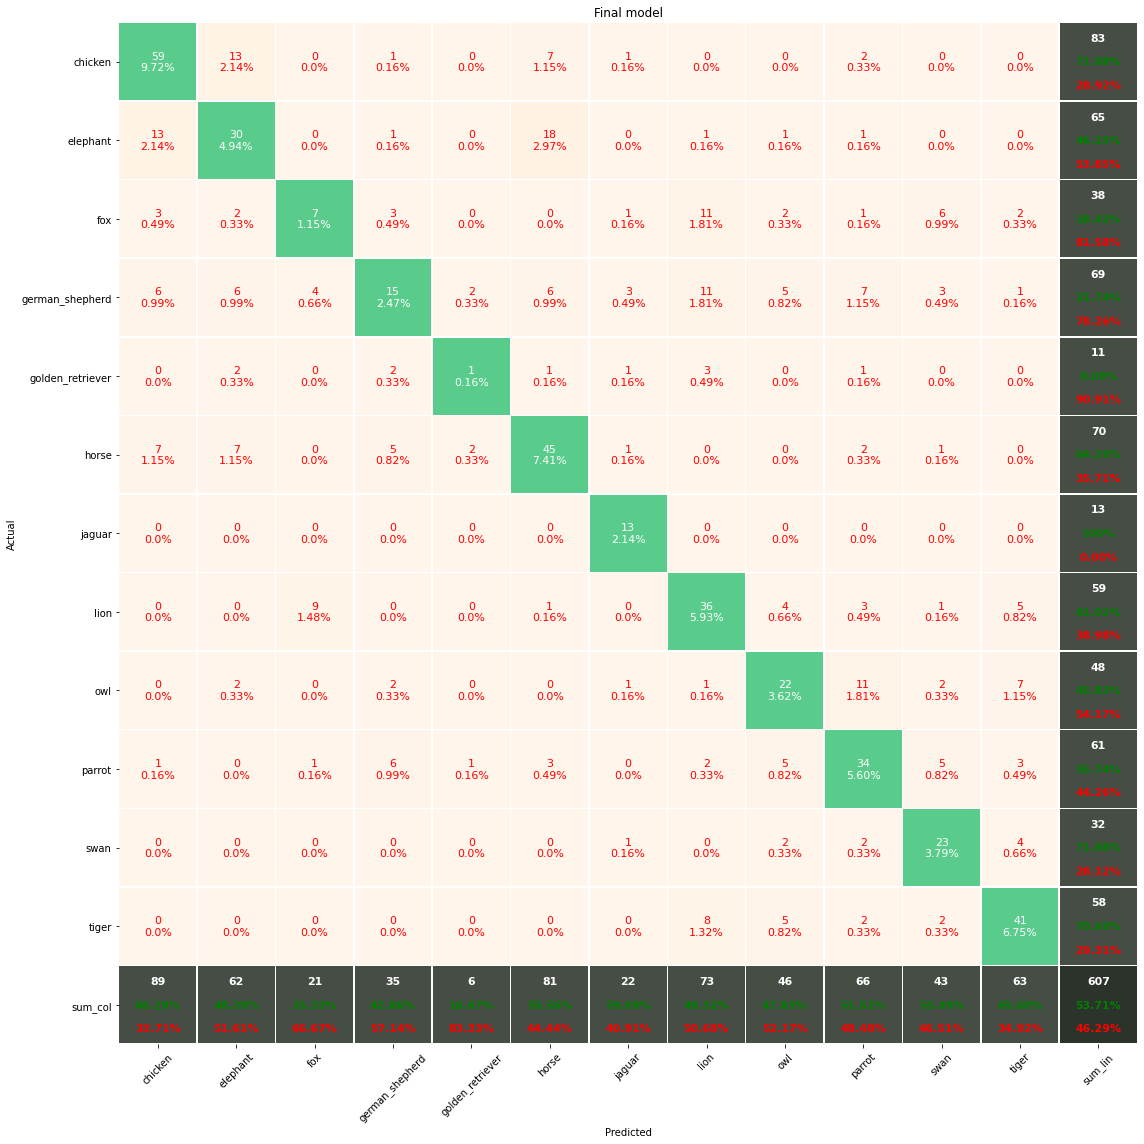

In [74]:
title = "Final model"
filename = "final_cm"

test_predicitons = model.predict(svc_test_data_split, lbm_test_data_split)
pretty_cm.plot_confusion_matrix_from_data(svc_test_labels_split, test_predicitons,
                                          columns=label_strings.tolist(), pred_val_axis="x",
                                          filename=filename, title=title)

### Model analysis of underlying models

This is done in the final_model_exploration notebook

In [73]:
print("Labels for full dataset:")
print(label_encoder.inverse_transform(range(0, 12)))
print()

print("Labels for merged dataset:")
print(label_encoder_merged.inverse_transform(range(0, 5)))
print()

print("Labels for dog dataset:")
print(label_encoder_dog.inverse_transform(range(0, 2)))
print()

print("Labels for dog only dataset:")
print(label_encoder_dog_only.inverse_transform(range(0, 2)))
print()

print("Labels for big only dataset:")
print(label_encoder_merged_big.inverse_transform(range(0, 2)))
print()

print("Labels for catish only dataset:")
print(label_encoder_merged_catish.inverse_transform(range(0, 4)))
print()

print("Labels for flying only dataset:")
print(label_encoder_merged_flying.inverse_transform(range(0, 3)))
print()




Labels for full dataset:
['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']

Labels for merged dataset:
['big' 'catish' 'chicken' 'dog' 'flying']

Labels for dog dataset:
['dog' 'others']

Labels for dog only dataset:
['german_shepherd' 'golden_retriever']

Labels for big only dataset:
['elephant' 'horse']

Labels for catish only dataset:
['fox' 'jaguar' 'lion' 'tiger']

Labels for flying only dataset:
['owl' 'parrot' 'swan']



## Other things

In [22]:
# put PC to sleep (handy if long calculation during the night)
import os
os.system("rundll32.exe powrprof.dll,SetSuspendState 0,1,0")

0